# Rare Variant Processing

In this notebook, I'm going to identify rare variants and annotate them.

In [1]:
import copy
import cPickle
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import pyBigWig
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_processing'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

phylop = pyBigWig.open('/publicdata/phyloP100way_20160224/hg19.100way.phyloP100way.bw')

fn = '/projects/CARDIPS/pipeline/WGS/annotateVCF/CARDIPS_201512.PASS.hg19.CADD.vcf.gz'
cadd = pd.read_table(fn, skiprows=1)
cadd.columns = [x.replace('#', '') for x in cadd.columns]
cadd.CHROM = 'chr' + cadd.CHROM.astype(str)
cadd.index = cadd.CHROM + ':' + cadd.POS.astype(str) + ':' + cadd.REF + ':' + cadd.ALT

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

In [5]:
log_tpm = np.log10(tpm + 1)

## SNVs and indels

Get SNVs and indels in promoters.

In [6]:
promoter_bt = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_merged.bed')
df = promoter_bt.to_dataframe()
s = '\n'.join(df.chrom.apply(lambda x: x[3:]) + '\t' + 
              df.start.astype(str) + '\t' + df.end.astype(str)) + '\n'
promoter_bt = pbt.BedTool(s, from_string=True)

In [7]:
vcfs = ['CARDIPS_chr{}_phased.vcf.gz'.format(x) for x in range(1, 23)]
vcfs = [os.path.join('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/', x) for x in vcfs]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_promoter_variants.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        c = 'bcftools view -Oz -R {} {} > {}'.format(promoter_bt.fn, vcf, out)
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)

Make merged bed file for roadmap DHSs for stem cell.

In [335]:
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

In [8]:
out = os.path.join(outdir, 'roadmap_stem_cell_dhs.bed')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    dhs_bt = pbt.BedTool(''.join([cpb.general.read_gzipped_text_url(url) for url in urls]), from_string=True)
    dhs_bt = dhs_bt.sort().merge()
    df = dhs_bt.to_dataframe()
    df.chrom = df.chrom.apply(lambda x: x[3:])
    s = '\n'.join(df.chrom + '\t' + df.start.astype(str) + 
                  '\t' + df.end.astype(str)) + '\n'
    dhs_bt = pbt.BedTool(s, from_string=True)
    dhs_bt.saveas(out)
else:
    dhs_bt = pbt.BedTool(out)

Get variants that overlap merged DHSs.

In [9]:
vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants.vcf.gz'.format(x)) 
        for x in range(1, 23)]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_dhs.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        temp = os.path.join(private_outdir, 'temp.vcf')
        c = 'bcftools view -m2 -M2 -Ov -R {} {} > {}'.format(dhs_bt.fn, vcf, temp)
        subprocess.check_call(c, shell=True)
        temp_header = os.path.join(private_outdir, 'temp_header.vcf')
        c = 'grep ^\\# {} > {}'.format(temp, temp_header)
        subprocess.check_call(c, shell=True)
        temp_lines = os.path.join(private_outdir, 'temp_lines.vcf')
        c = 'grep -v ^\\# {} | sort -k1,1 -k2,2n | uniq > {}'.format(temp, temp_lines)
        subprocess.check_call(c, shell=True)
        c = 'cat {} {} | bgzip > {}'.format(temp_header, temp_lines, out)
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)
        c = 'rm {} {} {}'.format(temp, temp_header, temp_lines)
        subprocess.check_call(c, shell=True)

Annotate variants with 1,000 genomes allele frequencies.

In [10]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
unr_rna_meta = pd.read_table(fn, index_col=0)
unrelateds = list(unr_rna_meta.wgs_id)

In [11]:
subject_meta.ix[unr_rna_meta.subject_id, 'ethnicity_group'].value_counts()

European                         94
Asian                            18
Multiple ethnicities reported     6
Hispanic                          6
African American                  3
Indian                            3
Middle Eastern                    1
Name: ethnicity_group, dtype: int64

In [12]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
promoters_t = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters.bed')

In [ ]:
out_fn = os.path.join(private_outdir, 'promoter_dhs_variants.pickle')
if not os.path.exists(out_fn):
    vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_dhs.vcf.gz'.format(x)) 
            for x in range(1, 23)]
    ind = []
    variants = []
    genotypes = []

    for vcf in vcfs:
        vcf_reader = pyvcf.Reader(open(vcf))
        for r in vcf_reader:
            s = [x.sample for x in r.samples if x.called]
            gt = [x.gt_alleles for x in r.samples if x.called]
            gt = pd.DataFrame(gt, index=s, columns=['allele_a', 'allele_b'])
            gt = gt.ix[unrelateds].dropna()
            unr_num_called = gt.shape[0]

            se = pd.Series(0, index=['0', '1'])
            vc = gt.allele_a.value_counts()
            se.ix[vc.index] += vc
            vc = gt.allele_b.value_counts()
            se.ix[vc.index] += vc
            uac = se.min()
            pos = 'chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS - 1 + len(r.REF))
            ind.append(pos)
            variants.append(['chr{}'.format(r.CHROM), r.POS - 1, r.POS - 1 + len(r.REF), 
                              r.ID, pos, r.REF, str(r.ALT[0]), uac, unr_num_called])
            se = pd.concat([pd.Series(0, index=[x.sample for x in r.get_hom_refs()]),
                            pd.Series(1, index=[x.sample for x in r.get_hets()]),
                            pd.Series(2, index=[x.sample for x in r.get_hom_alts()])])
            genotypes.append(se)

    cols = ['chrom', 'start', 'end', 'variant_id', 'position', 'ref', 'alt', 'unr_mac', 'unr_called']
    variants = pd.DataFrame(variants, index=ind, columns=cols)
    genotypes = pd.DataFrame(genotypes, index=ind)

    afs = ['AF', 'EUR_AF', 'SAS_AF', 'AFR_AF', 'AMR_AF', 'EAS_AF', 'VT']
    for c in afs:
        variants[c] = 0

    for chrom in set(variants.chrom):
        tdf = variants[variants.chrom == chrom]
        kgp_vcf_reader = pyvcf.Reader(open(
                '/publicdata/1KGP_20151103/ALL.{}.phase3_shapeit2_mvncall_integrated_v5a'
                '.20130502.genotypes.vcf.gz'.format(chrom)))
        for i in tdf.index:
            res = kgp_vcf_reader.fetch(chrom[3:], tdf.ix[i, 'start'] + 1, tdf.ix[i, 'start'] + 1)
            try:
                kgp = res.next()
                for c in afs:
                    variants.ix[i, c] = kgp.INFO[c][0]
            except StopIteration:
                continue
                
    # Annotate rare variants with their associated genes, transcripts, and promoters.
    s = '\n'.join(variants.chrom + '\t' + variants.start.astype(str) + '\t' + 
                  variants.end.astype(str) + '\t' + variants.position) + '\n'
    bt = pbt.BedTool(s, from_string=True).sort()

    # Annotate with genes.
    res = bt.intersect(promoters, sorted=True, wo=True)
    df = res.to_dataframe()
    df['gene'] = df.thickEnd.apply(lambda x: x.split('_')[0])
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    variants['genes'] = se.apply(lambda x: set(x))

    # Annotate with transcripts.
    res = bt.intersect(promoters_t, sorted=True, wo=True)
    df = res.to_dataframe()
    df['transcript'] = df.thickEnd.apply(lambda x: x.split('_')[0])
    gb = df[['name', 'transcript']].groupby('name')
    se = pd.Series(dict(list(gb['transcript'])))
    variants['transcripts'] = se.apply(lambda x: set(x))

    # Annotate with promoters.
    df['promoter'] = df.score + ':' + df.strand.astype(str) + '-' + df.thickStart.astype(str)
    gb = df[['name', 'promoter']].groupby('name')
    se = pd.Series(dict(list(gb['promoter'])))
    variants['promoters'] = se.apply(lambda x: set(x))

    # Drop any variants that don't have an annotated gene or transcript. This shouldn't 
    # happen but does for a handful for some reason.
    variants = variants[variants.genes.isnull() == False]
    variants = variants[variants.transcripts.isnull() == False]

    # Label indels.
    variants['indel'] = False
    variants.ix[(variants.end - variants.start != 1), 'indel'] = True
    
    # Get phyloP scores.
    max_cons = []
    min_cons = []
    mean_cons = []
    for i in variants.index:
        res = phylop.intervals(variants.ix[i, 'chrom'], variants.ix[i, 'start'], variants.ix[i, 'end'])
        if res is None:
            max_cons.append(np.nan)
            min_cons.append(np.nan)
            mean_cons.append(np.nan)
        else:
            max_cons.append(max([x[2] for x in res]))
            min_cons.append(min([x[2] for x in res]))
            mean_cons.append(np.mean([x[2] for x in res]))
    variants['max_phyloP100way'] = max_cons
    variants['min_phyloP100way'] = min_cons
    variants['mean_phyloP100way'] = mean_cons
    
    # CADD scores
    ind = variants.chrom + ':' + (variants.start + 1).astype(str) + ':' + variants.ref + ':' + variants.alt
    variants['cadd_rawscore'] = cadd.ix[ind, 'RawScore'].values
    variants['cadd_phred'] = cadd.ix[ind, 'PHRED'].values
    
    # Save object as pickle and genotypes.
    cPickle.dump(variants, open(out_fn, 'w'))
    
    fn = os.path.join(private_outdir, 'promoter_dhs_genotypes.tsv')
    genotypes.to_csv(fn, sep='\t')

In [333]:
out_fn = os.path.join(private_outdir, 'promoter_dhs_variants.pickle')
# Save object as pickle and genotypes.
cPickle.dump(variants, open(out_fn, 'w'))

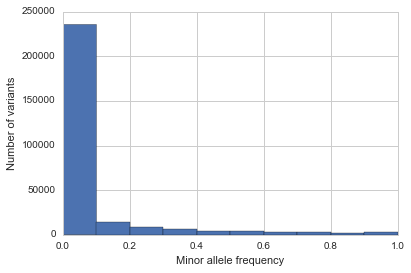

In [23]:
variants.AF.hist()
plt.ylabel('Number of variants')
plt.xlabel('Minor allele frequency');

In [ ]:
3 + 

### Transcription factor disruption

I want to annotate the rare variants with whether they disrupt
TF binding sites.

In [29]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
encode_tf_chip_seq = encode_tf_chip_seq[encode_tf_chip_seq.target.apply(lambda x: x in set(motif_info_rep.tf))]

In [31]:
out = os.path.join(private_outdir, 'tf_overlap.tsv')
if not os.path.exists(out):
    s = '\n'.join(rare_vars.chrom + '\t' + rare_vars.start.astype(str) + 
                  '\t' + rare_vars.end.astype(str) + '\t' + 
                  pd.Series(rare_vars.index, index=rare_vars.index)) + '\n'
    rv_bt = pbt.BedTool(s, from_string=True).sort()
    tf_overlap = pd.DataFrame(False, index=rare_vars.index, columns=encode_tf_chip_seq.target)

    for i in encode_tf_chip_seq.index:
        target = encode_tf_chip_seq.ix[i, 'target']
        s = cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url'])
        bt = pbt.BedTool(s, from_string=True)
        bt = bt.sort()
        res = rv_bt.intersect(bt, sorted=True, wo=True)
        df = res.to_dataframe(names=range(len(res[0].fields)))
        tf_overlap.ix[set(df[3]), target] = True
    tf_overlap.to_csv(out, sep='\t')
else:
    tf_overlap = pd.read_table(out, index_col=0)

In [34]:
out = os.path.join(private_outdir, 'tf_disruption.tsv')
if not os.path.exists(out):
    tdf = tf_overlap[tf_overlap.sum(axis=1) > 0]
    var_tf_overlaps = {}
    for i in tdf.index:
        se = tdf.ix[i]
        se = se[se]
        var_tf_overlaps[i] = list(motif_info[motif_info.tf.apply(lambda x: x in se.index)].index)
    tf_disruption = pd.DataFrame(False, index=tf_overlap.index, columns=tf_overlap.columns)

    from ipyparallel import Client
    # parallel_client = Client(profile='parallel')
    parallel_client = Client()
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(rare_vars=rare_vars));
    dview.push(dict(var_tf_overlaps=var_tf_overlaps));
    dview.push(dict(matrices=matrices));
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            rare_vars.ix[i, 'position'], rare_vars.ix[i, 'ref'], rare_vars.ix[i, 'alt'], 
            cpy.hg19, {k:matrices[k] for k in matrices.keys() if k in var_tf_overlaps[i]}), 
                         var_tf_overlaps.keys())
    for i,k in enumerate(var_tf_overlaps.keys()):
        if res[i].shape[0] > 0:
            tf_disruption.ix[k, set(motif_info.ix[res[i][res[i]['score_diff'].abs() >= 2.5].index, 'tf'])] = True
    tf_disruption.to_csv(out, sep='\t')
else:
    tf_disruption = pd.read_table(out, index_col=0)

Cluster has 20 engines.
importing cdpybio on engine(s)
importing cardipspy on engine(s)


### Dinucleotide substitutions

I want to collect some information on dinucleotide substitutions so I can see
if samples have the CC->TT mutations associated with UV damage.

In [ ]:
# Note: I ran this at the command line so these commands need to be checked to make sure they work.
out = os.path.join(private_outdir, 'adj.vcf.gz')
if not os.path.exists(out):
    temp = os.path.join(private_outdir, 'temp.vcf')
    header = os.path.join(private_outdir, 'header.vcf')
    ! bcftools view --max-ac 1:minor -i 'ID="."' -m2 -M2 -v snps \
        /projects/CARDIPS/pipeline/WGS/mergedVCF/CARDIPS_201512.PASS.vcf.gz \
        | awk 'BEGIN {pos=0 ; prev=""} {if (pos==$2) print prev"\n"$0 ; pos=$2+1 ; prev=$0}' \
        | uniq > {temp}
    ! zcat /projects/CARDIPS/pipeline/WGS/mergedVCF/CARDIPS_201512.PASS.vcf.gz | head -n 1000 | grep ^\# > {header}
    ! cat {header} {temp} > {out[0:-3]}
    ! bgzip {out[0:-3]}
    ! tabix -p vcf {out}
    ! rm {temp} {header}

In [146]:
out = os.path.join(private_outdir, 'adj_info.tsv')
if not os.path.exists(out):
    vals = {'sample':[], 'ref':[], 'alt':[]}

    vcf_reader = pyvcf.Reader(open(os.path.join(private_outdir, 'adj.vcf.gz')))
    while True:
        try:
            line_one = vcf_reader.next()
            line_two = vcf_reader.next()
            if line_two.POS - 1 != line_one.POS:
                line_one = line_two
                line_two = vcf_reader.next()
            assert line_two.POS - 1 == line_one.POS

            hets_one = line_one.get_hets()
            hets_two = line_two.get_hets()
            if len(hets_one) == len(hets_two) == 1:
                sone = hets_one[0].sample
                stwo = hets_two[0].sample

                if sone == stwo:
                    vals['sample'].append(sone)
                    vals['ref'].append(line_one.REF + line_two.REF)
                    vals['alt'].append(str(line_one.ALT[0]) + str(line_two.ALT[0]))
        except StopIteration:
            break
    adj_info = pd.DataFrame(vals)
    adj_info['substitution'] = adj_info.ref + ':' + adj_info.alt
    adj_info.to_csv(out, sep='\t')

In [147]:
adj_info.substitution.value_counts()

CC:TT    7422
GG:AA    7100
TG:CA     701
CA:TG     622
GC:TT     591
GC:AA     534
GA:TT     307
GC:AT     303
GA:AT     291
TC:AA     267
TC:AT     256
TC:CT     228
GA:AG     224
GG:TT     212
CC:AA     199
CA:AG     174
AA:TT     174
TG:CT     168
GG:AC     165
GG:AT     144
CC:GT     141
GC:AG     137
GA:AC     134
AC:TT     134
CA:AT     129
CC:AT     128
GT:AA     127
CT:TC     123
CA:TT     123
TA:AT     122
         ... 
GG:CC      26
TG:AC      26
AA:TG      26
AA:CT      25
TT:CA      25
AC:TG      22
CA:GC      22
CG:TC      22
AT:GG      22
TG:GC      21
AA:CG      21
TA:GG      20
AA:CC      19
CG:AT      19
CA:GT      19
GA:CG      16
CG:GC      16
AT:CG      15
GA:CC      15
TT:CG      15
CG:GA      14
TC:CG      14
TC:GG      14
TA:GC      13
CG:GT      11
GT:CA      10
GT:CG       8
GC:CG       8
AC:CG       8
CG:AC       8
Name: substitution, dtype: int64

In [148]:
gb = adj_info.groupby('sample')

In [149]:
vc = adj_info['sample'].value_counts()

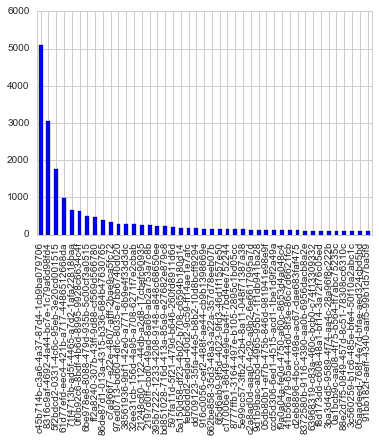

In [151]:
vc[vc > 100].plot(kind='bar');

In [140]:
gb.substitution.value_counts()['63968319-c83a-460c-bcb0-c74f13309332']

substitution
GA:AG    3
AG:TC    2
CA:TT    2
CT:TC    2
GC:CT    2
TA:AT    2
TC:AT    2
TC:CT    2
AA:GG    1
AC:GG    1
AG:TA    1
CA:AC    1
CA:GG    1
CA:TG    1
CC:AA    1
CT:AC    1
CT:TG    1
GA:CT    1
GA:TG    1
GA:TT    1
GC:AT    1
GC:TA    1
GT:AA    1
TA:AG    1
TG:AA    1
TG:AT    1
TG:CC    1
TG:CT    1
TT:AG    1
TT:GA    1
dtype: int64

In [126]:
tdf.head()

,alt,ref,sample,substitution
0,AA,GG,8316c9af-4692-4a44-bc7e-1c79a6d98fd4,GG:AA
1,AA,GG,97ed0713-bd60-4dfc-8035-e7bb6740d020,GG:AA
2,TT,CC,ff2a8240-307b-43ff-9d88-cf569d566780,CC:TT
3,TT,CC,8316c9af-4692-4a44-bc7e-1c79a6d98fd4,CC:TT
4,AA,GG,c45b714b-c3a6-4a37-87d4-1cb9ba079706,GG:AA


## Rare CNVs

In [237]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/gs_info.pickle')
gs_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/gs_genotypes.tsv')
gs_geno = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/lumpy_info.pickle')
lumpy_info = cPickle.load(open(fn))
lumpy_info['start'] = lumpy_info.pos
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/lumpy_genotypes.tsv')
lumpy_geno = pd.read_table(fn, index_col=0)

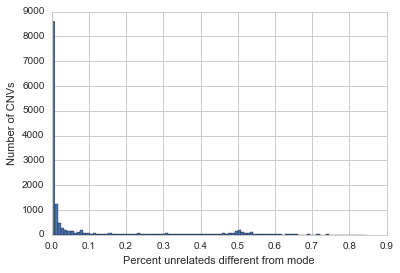

In [238]:
gs_info.unrelated_percent_diff_from_mode.hist(bins=100)
plt.ylabel('Number of CNVs')
plt.xlabel('Percent unrelateds different from mode');

In [239]:
gs_info.sort_values(by='unrelated_diff_from_mode', inplace=True)

I'm going to filter the lumpy calls a bit.

In [240]:
lumpy_info = lumpy_info[lumpy_info.su >= 14]
lumpy_geno = lumpy_geno.ix[lumpy_info.index, unrelateds]
lumpy_rare_geno = lumpy_geno[lumpy_geno.sum(axis=1) == 1]
lumpy_rare_info = lumpy_info.ix[lumpy_rare_geno.index]

In [242]:
cols = list(set(lumpy_rare_info.columns) & set(gs_info.columns))
rare_cnv_info = pd.concat([lumpy_rare_info[cols], gs_info.ix[gs_info.unrelated_diff_from_mode == 1, cols]])
# rare_cnv_info = gs_info[gs_info.unrelated_diff_from_mode == 1]
rare_cnv_info = rare_cnv_info.dropna(subset=['overlaps_gene'])

rare_cnv_info['caller'] = 'genomestrip'
rare_cnv_info.ix[rare_cnv_info.name.apply(lambda x: 'DEL' in x), 'caller'] = 'lumpy'
rare_cnv_info.ix[rare_cnv_info.name.apply(lambda x: 'DUP' in x), 'caller'] = 'lumpy'

In [243]:
rare_cnv_info['sample'] = np.nan

In [244]:
rare_cnv_info['svtype'] = np.nan
ind = rare_cnv_info[rare_cnv_info.caller == 'lumpy'].index
rare_cnv_info.ix[ind, 'svtype'] = lumpy_info.ix[ind, 'svtype']

In [245]:
samples = []
for i in ind:
    se = lumpy_geno.ix[i, unrelateds]
    samples.append(se[se == 1].index[0])
rare_cnv_info.ix[ind, 'sample'] = samples

In [246]:
samples = []
ind = rare_cnv_info[rare_cnv_info.caller == 'genomestrip'].index
for i in ind:
    vc = gs_geno.ix[i, unrelateds].value_counts()
    mi = vc[vc == vc.min()].index[0]
    ma = vc[vc == vc.max()].index[0]
    if mi < ma:
        rare_cnv_info.ix[i, 'svtype'] = 'DEL'
    elif mi > ma:
        rare_cnv_info.ix[i, 'svtype'] = 'DUP'
    se = gs_geno.ix[i, unrelateds]
    samples.append(se[se == mi].index[0])
rare_cnv_info.ix[ind, 'sample'] = samples

Remove MHC CNVs.

In [247]:
mhc_bt = pbt.BedTool('chr6\t{}\t{}'.format(int(29.6e6), int(33.1e6)), from_string=True)
s = '\n'.join(rare_cnv_info.chrom + '\t' + rare_cnv_info.start.astype(str) + '\t' + 
              rare_cnv_info.end.astype(str) + '\t' + rare_cnv_info.name) + '\n'
rare_cnv_bt = pbt.BedTool(s, from_string=True)
res = rare_cnv_bt.intersect(mhc_bt, v=True, wa=True)
df = res.to_dataframe()
rare_cnv_info = rare_cnv_info.ix[df.name]

In [248]:
rare_cnv_info['sample'].value_counts().head()

4fc00735-6005-4e26-a5d9-3008c62aa632    873
32ee31cb-156d-4a95-a708-6271f7e2cbab    164
ebb69264-564b-49ee-b013-86e83a1b9f49    161
916c0056-cef2-488f-ae44-cb9b1398669e    120
63968319-c83a-460c-bcb0-c74f13309332     86
Name: sample, dtype: int64

In [249]:
subject_meta.ix[wgs_meta.ix['4fc00735-6005-4e26-a5d9-3008c62aa632', 'subject_id']]

sex                                                   M
age                                                64.7
family_id          6130d59b-8343-4628-9c67-aff53dabc4b4
father_id                                           NaN
mother_id                                           NaN
twin_id                                             NaN
ethnicity_group                                European
Name: 0ad8c77c-4d4b-4bac-9f16-99c2ab84ee81, dtype: object

In [253]:
cPickle.dump(rare_cnv_info, open(os.path.join(private_outdir, 'rare_cnvs.pickle'), 'w'))